<h1>LIBRARIES</ha

In [60]:
!pip install fuzzywuzzy

In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

<h1>LOADING LIBRARIES</h1>

In [2]:
#  Load data, take only necessary columns and set data types
df_movie = pd.read_csv('movies.csv', usecols=['movieId','title'], dtype={'movieId':'int32', 'title':'str'})
df_movie.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [3]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   object
dtypes: int32(1), object(1)
memory usage: 114.3+ KB


In [4]:
df_rate = pd.read_csv('ratings.csv', usecols=['movieId','userId','rating'], 
                                    dtype={'movieId':'int32','userId':'int32','rating':'float32'})
df_rate.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
df_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [6]:
num_users = len(df_rate.userId.unique())
num_movies = len(df_rate.movieId.unique())
print('There are {} unique users involve rating {} movies'.format(num_users, num_movies))

There are 610 unique users involve rating 9724 movies


<h1>EDA</h1>

Let's count how many numbers of rating for each rating level.

In [7]:
df_cnt_rating = pd.DataFrame(df_rate.groupby('rating').size(), columns=['count'])
df_cnt_rating

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


We can see that the level of rating spreads from 0.5 to 5.0.<br>
Why don't we have 0.0 rating? Actually, the system does not contain such rating, because when a user rates a movie, he/she must put the rating at least 0.5 and maximum is 5.0.</br>
Additionally, it is hard for a user to watch all movies and rate them. They just rate the movies which they watched. If all users rate all movies, the number of rows in rating dataset must be num_users * num_movies.</br>
Therefore, we will set 0.0 rating level in our dataset and consider it as the lack of rating (it means user has not watched movie yet).</br>

In [8]:
total = num_users * num_movies
num_zero_rating = total - df_rate.shape[0]

# Add this count into the dataframe of rating statistic
df_cnt_rating_full = pd.concat([df_cnt_rating, pd.DataFrame({'count':num_zero_rating}, index=[0.0])]).sort_index()
df_cnt_rating_full

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Start plotting a bar chart to have a more visual view. 

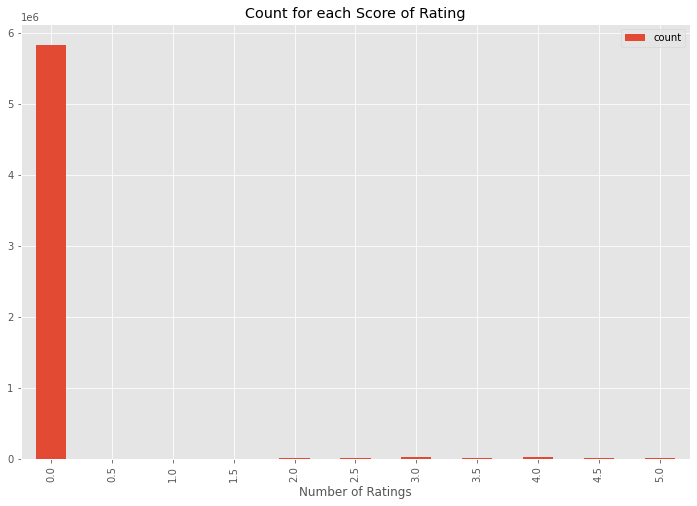

In [9]:
ax = df_cnt_rating_full[['count']].reset_index().rename(columns={'index':'Rating score'}).plot(x='Rating score',
                                                                                          y='count',
                                                                                          kind='bar',
                                                                                          figsize=(12,8),
                                                                                          title='Count for each Score of Rating')
ax.set_xlabel('Rating Scores')
ax.set_xlabel('Number of Ratings')
plt.show()

It is because the number of 0.0 rating is too much higher than others. We need to apply Log method to scale down them all.

In [10]:
# df_cnt_rating_full['log_count'] = np.log(df_cnt_rating_full['count'])
# df_cnt_rating_full

In [11]:
# # Plot again with feature logy = True
# ax = df_cnt_rating_full[['log_count']].reset_index().rename(columns={'index':'Rating score'}).plot(x='Rating score',
#                                                                                           y='log_count',
#                                                                                           kind='bar',
#                                                                                           figsize=(12,8),
#                                                                                           title='Count for each Score of Rating')
# ax.set_xlabel('Rating Scores')
# ax.set_xlabel('Number of Ratings')
# plt.show()

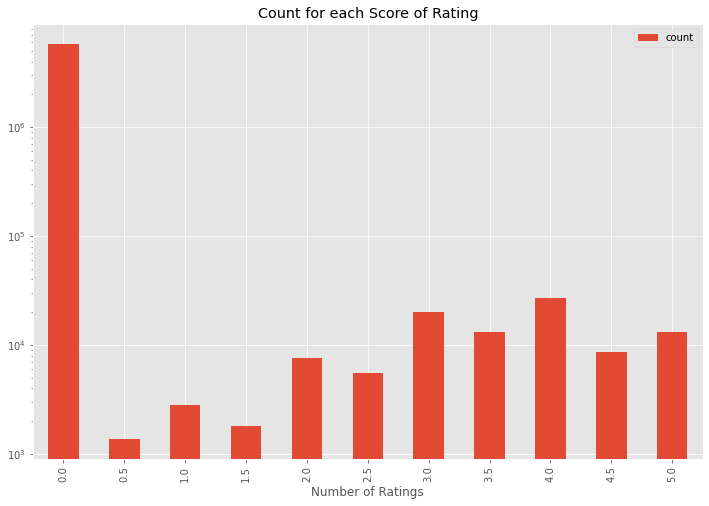

In [12]:
# Plot again with feature logy = True
ax = df_cnt_rating_full[['count']].reset_index()\
                                  .rename(columns={'index':'Rating score'})\
                                  .plot(x='Rating score',
                                        y='count',
                                        kind='bar',
                                        figsize=(12,8),
                                        title='Count for each Score of Rating',
                                        logy=True)
ax.set_xlabel('Rating Scores')
ax.set_xlabel('Number of Ratings')
plt.show()

Next, we will continue to analyze the popularity of movies. Because there are movies that have a lot of views, while the others are not.

In [13]:
df_movie_rt = pd.DataFrame(df_rate.groupby('movieId').size(), columns=['count'])
df_movie_rt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


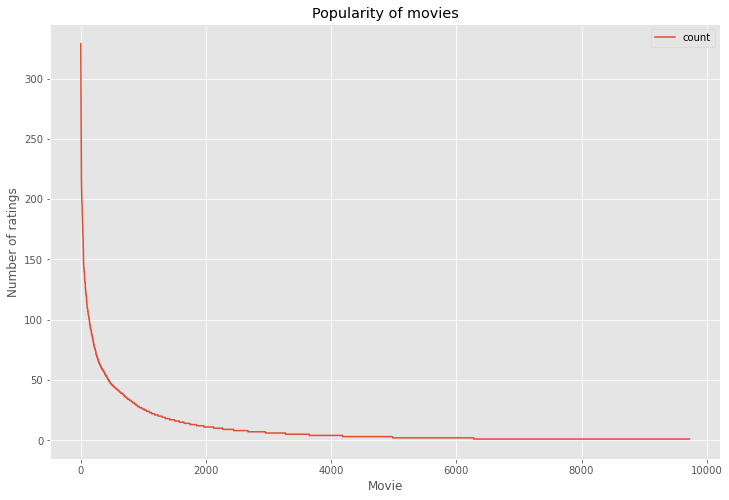

In [14]:
ax = df_movie_rt.sort_values('count', ascending=False)\
                .reset_index(drop=True)\
                .plot(figsize=(12,8),
                      title='Popularity of movies')
ax.set_xlabel('Movie')
ax.set_ylabel('Number of ratings')
plt.show()

We can see that there is a huge difference in popularity of those movies.<br>
There are some movies are frequently rated, but there are others opposite. This will result a highly skewed distribution in this dataset.<br>

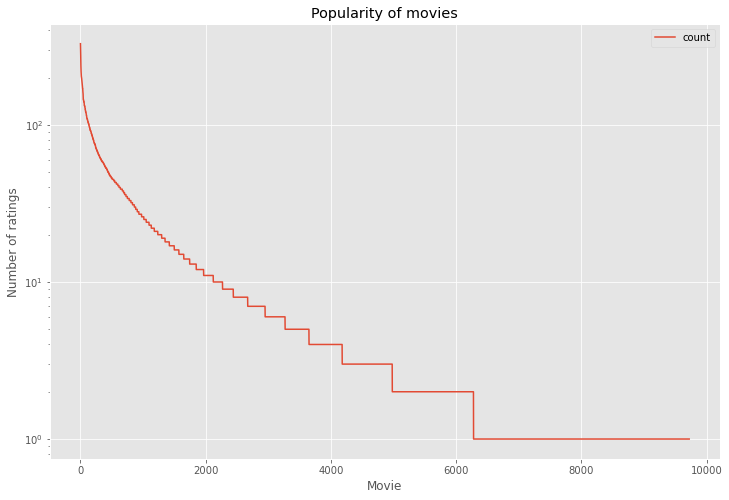

In [15]:
ax = df_movie_rt.sort_values('count', ascending=False)\
                .reset_index(drop=True)\
                .plot(figsize=(12,8),
                      title='Popularity of movies',
                      logy=True)
ax.set_xlabel('Movie')
ax.set_ylabel('Number of ratings')
plt.show()

We can see that in 9724 movies, there are roughly 2000 movies which have 10 or more number of ratings.<br>
Let's apply quantile to have a closer look on distribution of this dataset.<br>

In [16]:
df_movie_rt['count'].quantile(np.arange(1,0.6,-0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

We can see that there is only 1% of all movies have 329 ratings, 5% has 47 ratings and 25% have 9 ratings.<br>
We will consider and choose a threshold to limit the number of movies we should use for training model. It is because we have a lot of movies which have small number of ratings or even don't have any rating. If we take also those movies, it will affect to accuracy of our model.</br>
Let's choose movies have 50 or more ratings.<br>

In [17]:
thresh = 50
popular_movies_index = list(set(df_movie_rt.query('count >= @thresh').index))

After getting the index of popular movies, we will exact their number of ratings from the rating dataset

In [18]:
df_popular_rate = df_rate[df_rate['movieId'].isin(popular_movies_index)]
df_popular_rate.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [19]:
num_popular = len(df_popular_rate)
num_rating = len(df_rate)
print('There are {} rating for popular movies out of {} rating in dataset.'.format(num_popular, num_rating))

There are 41360 rating for popular movies out of 100836 rating in dataset.


At this step, we filtered out the rating of unpopular movies.<br>
We will continue to explore our dataset with another point of view from user.<br>
As our analysis about movies, we filtered out unpopular movies because it will affect to our model, we also need to check the users who less involve to rate movies. Because we need to build model based on trustworthy rating.

In [20]:
df_user_rt = pd.DataFrame(df_popular_rate.groupby('userId').size(), columns=['count'])
df_user_rt

,count
userId,
1,117
2,15
3,6
4,84
5,34
...,...
606,238
607,100
608,309


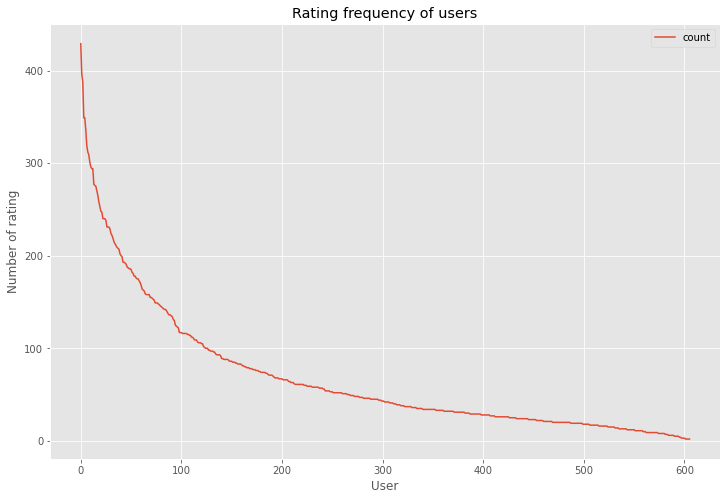

In [21]:
ax = df_user_rt.sort_values('count', ascending=False)\
               .reset_index(drop=True)\
               .plot(figsize=(12,8),
                     title='Rating frequency of users')
ax.set_xlabel('User')
ax.set_ylabel('Number of rating')
plt.show()

In [22]:
df_user_rt['count'].quantile(np.arange(1,0.6,-0.05))

1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
Name: count, dtype: float64

We can also see that, there is only tiny fraction of users proactively rated movies they watched.<br>
To get the trustworthy rating, we will limit to take the top proactive users.<br>

In [23]:
# Get user ID of proactive users
thresh = 50
popular_user_index = list(set(df_user_rt.query('count >= @thresh').index))

# Exact ratings from those users
df_proactive_rate = df_popular_rate[df_popular_rate['userId'].isin(popular_user_index)]
df_proactive_rate.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [24]:
print('There are {} ratings from proactive users'.format(len(df_proactive_rate)))

There are 32999 ratings from proactive users


<h1>BUILDING KNN MODEL</h1>

To build a KNN model, firstly, we need to convert our dataset to be a user/item matrix, it can be considered as a pivot table.<br>
The user/item matrix will have each row represent to 1 movie and each column for 1 user.<br>
We recognize that there will be some missing value due to a user did not rate movies. Let's solve it by fillna.<br>

In [25]:
ui_matrix = df_proactive_rate.pivot(index='movieId', columns='userId', values='rating').fillna(0)
ui_matrix.head()

userId,1,4,6,7,15,16,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,2.5,0.0,4.5,3.5,4.0,0.0,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
7,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,3.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0


In [55]:
ui_matrix.shape

(450, 268)

You will see that we receive a quite big matrix, but almost of all values in this matrix are 0 because a user just watched a certain number of movies.<br>
Building a ML model on this big matrix is very wasteful of time and memory. Moreover, a lot of 0 value is simply ineffcient for model.<br>
So we need to convert this matrix to a sparse matrix for effective consumption.<br>

In [53]:
ui_matrix_sparse = csr_matrix(ui_matrix.values)

Take the title of movies from movie dataset but just take only movies that have index in the user/item/matrix. Also set new index for the list of movies.<br>

In [85]:
df_movie_recsys = {i: mv for i, mv in enumerate(list(df_movie.set_index('movieId').loc[ui_matrix.index].title))}
list(df_movie_recsys.items())[:5]

[(0, 'Toy Story (1995)'),
 (1, 'Jumanji (1995)'),
 (2, 'Grumpier Old Men (1995)'),
 (3, 'Heat (1995)'),
 (4, 'Sabrina (1995)')]

Initilize KNN model with all setting parameters.

In [107]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

After defining KNN model, we will use fuzzy algorithm to find out the closest match movies.

In [108]:
def fuzzy_matching(mapper:dict, fav_item:str, verbose:bool=True):
    """
    mapper: dict, map movie title name to index of the movie in data
    fav_item: str, name of input movie
    verbose: bool, print log if True
    Returns: index of the closest match
    """
    match_tuple = []
    # Calculation fuzzy ratio between the input movie title and all movies title. 
    # Take only movies which have 60 or more matching score
    for idx, title in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_item.lower())
        if ratio >= 60:
            match_tuple.append((idx, title, ratio))
            
    # Sort descending the matching list based on ratio score
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('No match is found!')
        return
    return match_tuple[0][0]

In [109]:
def make_recommendation(model_knn, data, mapper:dict, fav_item:str, n_recommendations:int):
    """
    return top n similar movie recommendations based on user's input movie
    Args
    ----
    model_knn: knn model
    data: user/item matrix
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of the input movie
    n_recommendations: int, top n recommendations
    ----
    Returns: list of top n similar movie recommendations
    """
    # training KNN model
    model_knn.fit(data)
    
    # get index of input movie 
    idx = fuzzy_matching(mapper, fav_item, verbose=True)
    
    # Model compute distance between the favorite movie and the others
    # we use n_recommendations+1 because the result will include the input movie. Then we will take only the 10 others
    print('Recommendation system start computating similar movies')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1) 
    
    # get list of raw index of recommendations and sort by distance
    # [1:] The first index (0) will be the input movie, so we take similar movies from the second position
    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[1:]
    
    # print recommendations
    print('Recommendations for the movie you are watching "{}": '.format(fav_item))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}'.format(i+1, mapper[idx]))

<h1>TEST</h1>

In [110]:
watching_movie = 'Godfather: Part II, The (1974)'

make_recommendation(
    model_knn=knn,
    data=ui_matrix_sparse,
    fav_item=watching_movie,
    mapper=df_movie_recsys,
    n_recommendations=10)

Recommendation system start computating similar movies
......

Recommendations for the movie you are watching "Godfather: Part II, The (1974)": 
1: Godfather, The (1972)
2: Reservoir Dogs (1992)
3: Goodfellas (1990)
4: Star Wars: Episode IV - A New Hope (1977)
5: Usual Suspects, The (1995)
6: Star Wars: Episode V - The Empire Strikes Back (1980)
7: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
8: Star Wars: Episode VI - Return of the Jedi (1983)
9: One Flew Over the Cuckoo's Nest (1975)
10: Matrix, The (1999)
